## Library

In [1]:
#!pip install pycbrf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import pycbrf
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 14

## Data Plot

In [4]:
df = pd.read_csv("data_182.csv", index_col='date', sep=';', encoding='utf-8')

In [5]:
df.head()

,currency,digital_code,letter_code,rate
date,,,,
1924-01-01,Доллар США,840.0,USD,2.20
1924-01-01,Фунт стерлингов Соединенного королевства,826.0,GBP,9.40
1924-01-01,Шведская крона,752.0,SEK,0.55
1924-02-01,Доллар США,840.0,USD,2.17
1924-02-01,Фунт стерлингов Соединенного королевства,826.0,GBP,9.24


In [6]:
df = pd.DataFrame(df[df.currency=="Доллар США"]["rate"])

In [7]:
df.head()

,rate
date,
1924-01-01,2.2000
1924-02-01,2.1700
1924-03-01,2.1100
1924-03-08,2.0000
1924-04-01,1.9405


<AxesSubplot:xlabel='date'>

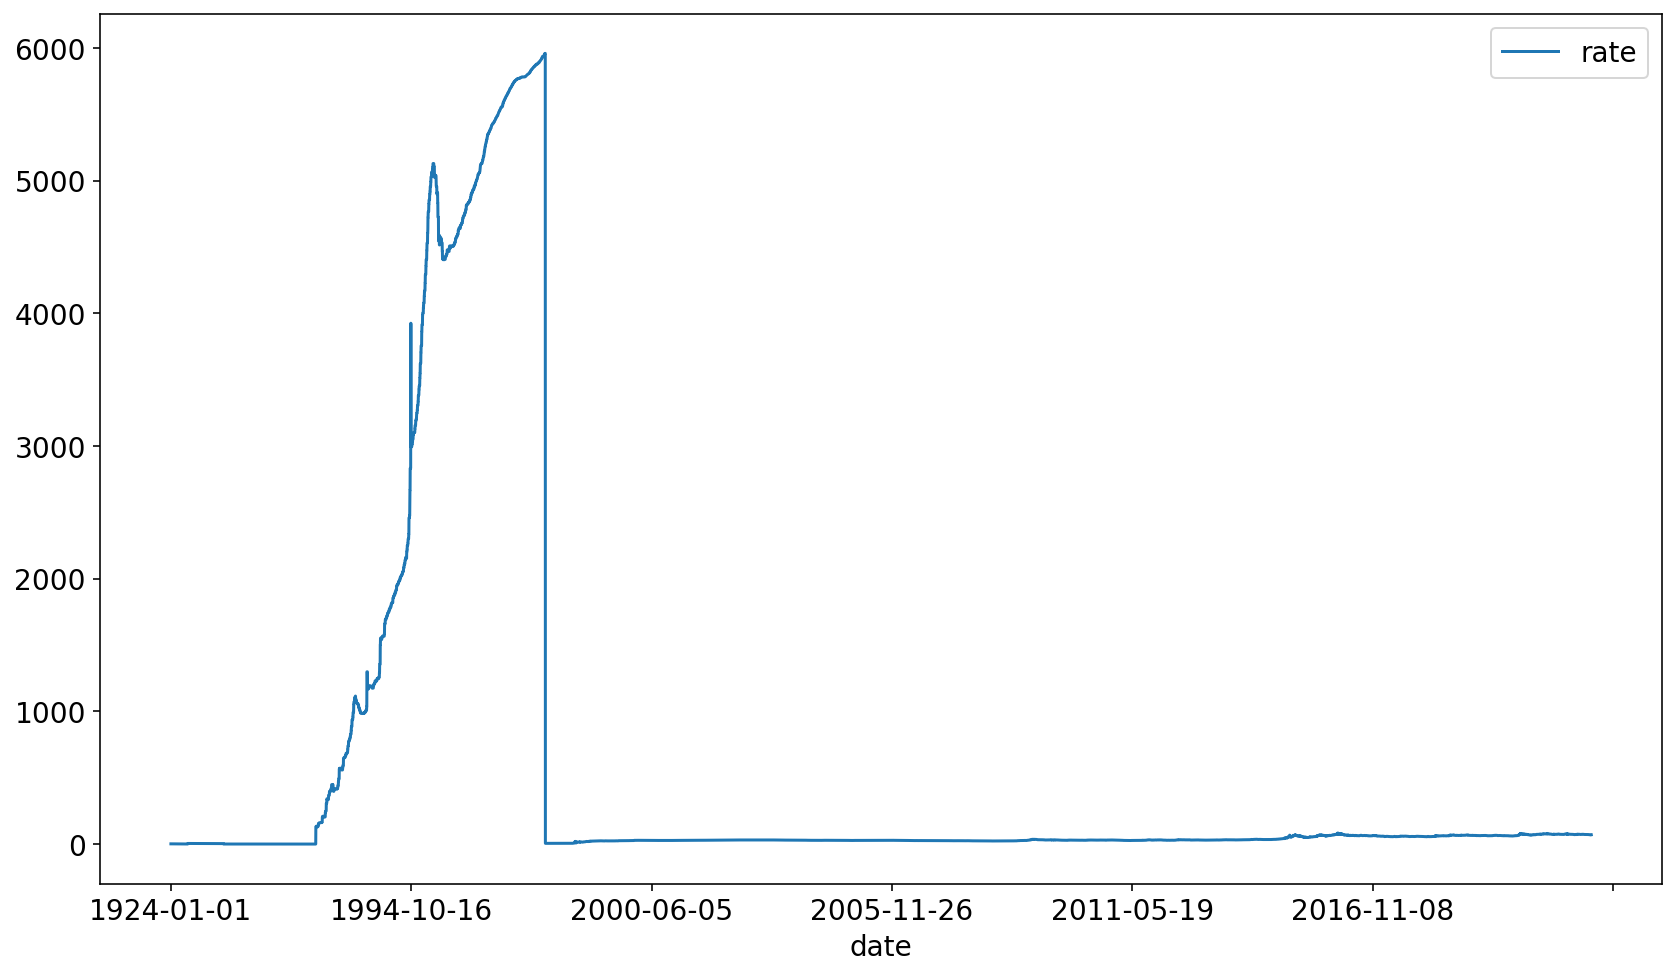

In [8]:
df.plot()

In [9]:
from pycbrf import ExchangeRates

In [10]:
start_date = datetime(2021, 11, 1)
end_date = datetime.today()
delta = end_date - start_date
addDays = timedelta(days=1)
last_received = datetime(2021, 11, 1)

cbrf_data = {}

with tqdm(total=delta.days) as pbar:
    while start_date <= end_date:
        cbrf = ExchangeRates(start_date.strftime("%Y-%m-%d"))
        if last_received != cbrf.date_received:
            cbrf_data[start_date.strftime("%Y-%m-%d")] = float(cbrf["USD"].rate)
            last_received = cbrf.date_received
        start_date += addDays
        pbar.update(1)

463it [00:19, 23.66it/s]                                                                                               


In [11]:
cbrf_df = pd.DataFrame(cbrf_data.items(), columns=["date", "rate"]).set_index("date")

In [12]:
df = df.append(cbrf_df)

<AxesSubplot:xlabel='date'>

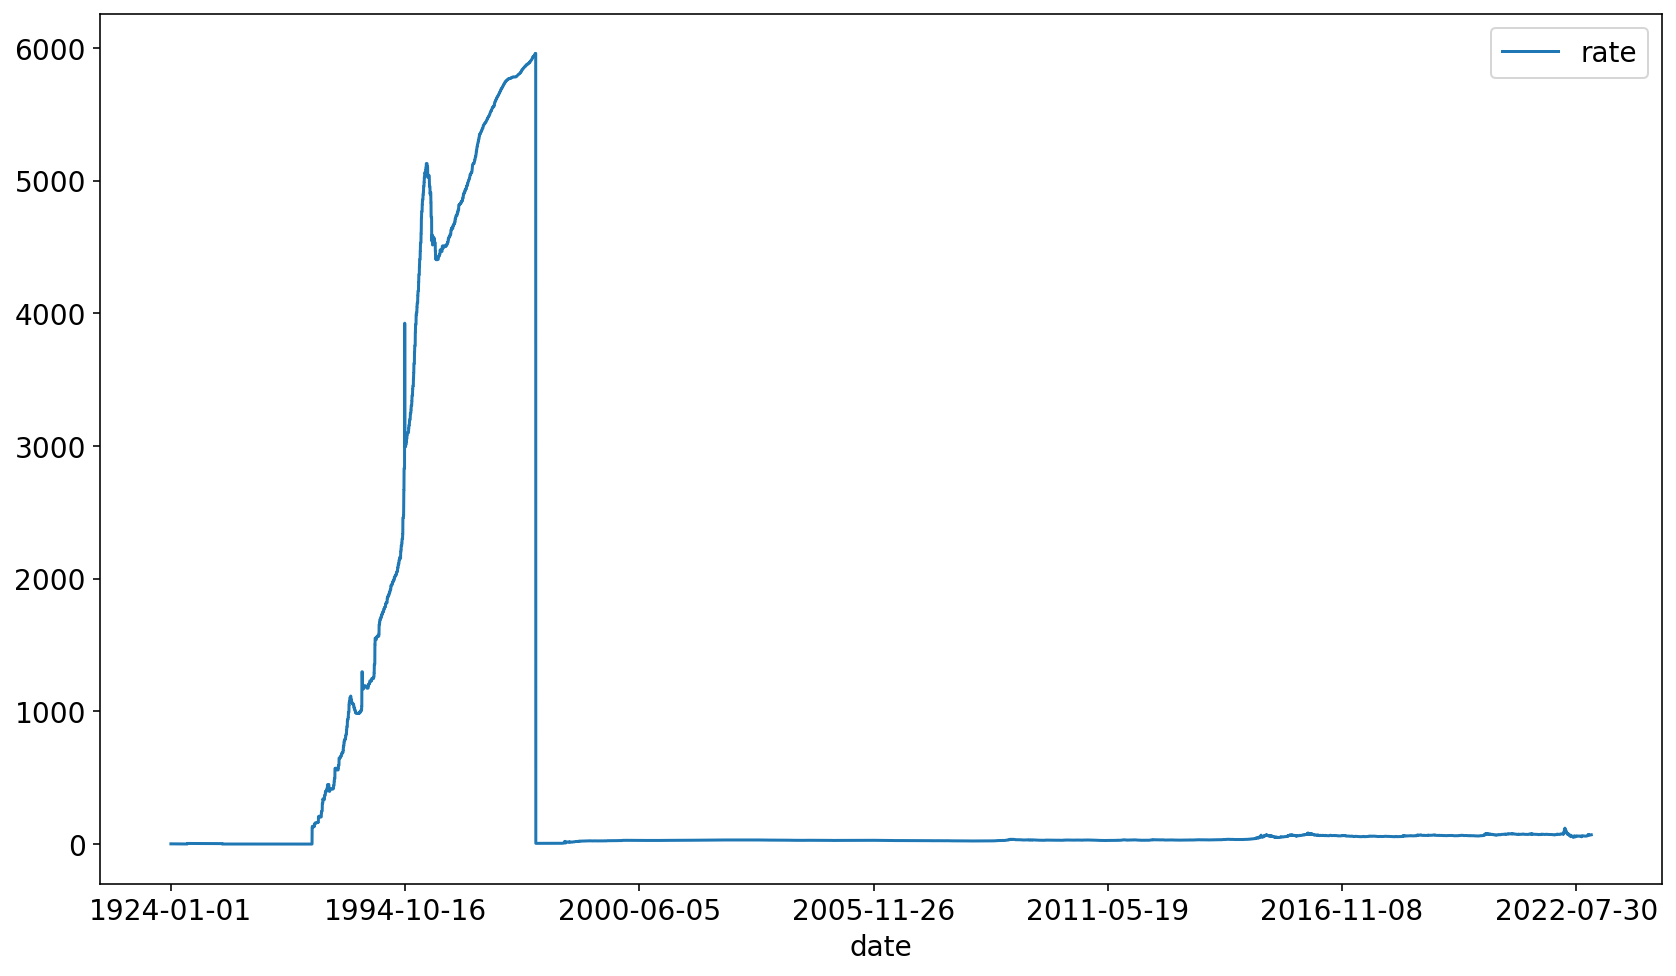

In [13]:
df.plot()

In [14]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [15]:
df = df[df.index > pd.Timestamp(2014, 1, 1)]

<AxesSubplot:xlabel='date'>

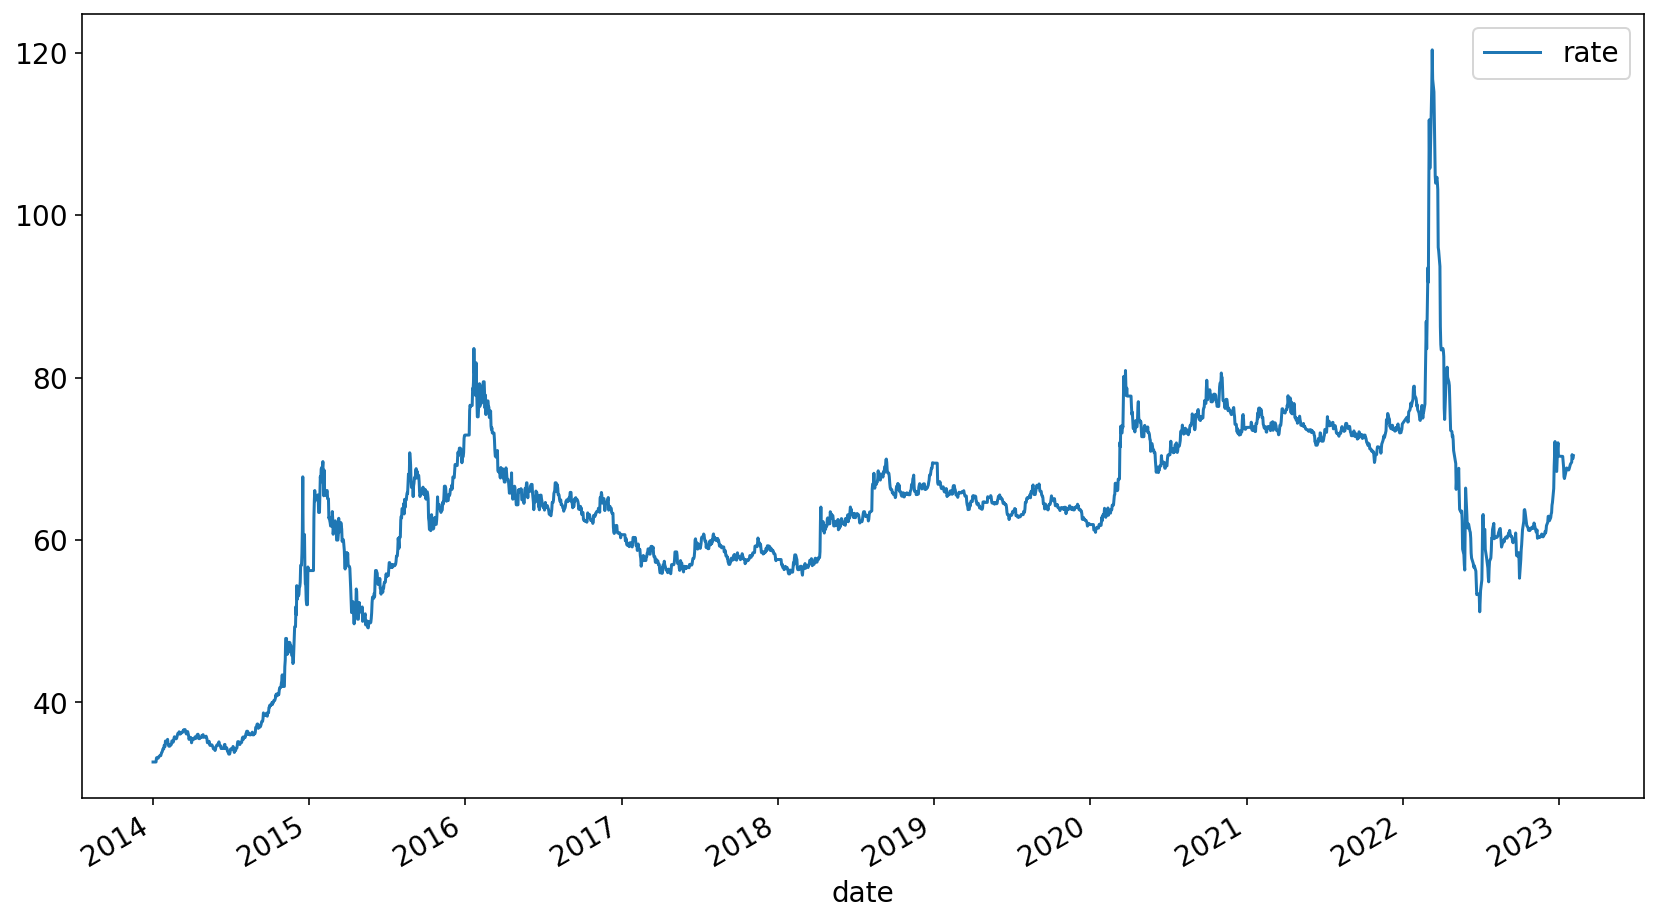

In [16]:
df.plot()

In [17]:
df = df["rate"].values.reshape(df.shape[0], 1)

## Dataloading

In [18]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(df)

seq_length = 50
x, y = sliding_windows(df, seq_length)

train_size = int(len(y) * 0.87)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [19]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [20]:
num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 16
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 3876.35596
Epoch: 100, loss: 2076.11670
Epoch: 200, loss: 955.00494
Epoch: 300, loss: 439.26828
Epoch: 400, loss: 206.97147
Epoch: 500, loss: 91.44280
Epoch: 600, loss: 46.71141
Epoch: 700, loss: 27.08225
Epoch: 800, loss: 17.55926
Epoch: 900, loss: 11.99203
Epoch: 1000, loss: 8.32262
Epoch: 1100, loss: 5.84240
Epoch: 1200, loss: 4.16676
Epoch: 1300, loss: 3.02826
Epoch: 1400, loss: 2.26383
Epoch: 1500, loss: 1.76145
Epoch: 1600, loss: 1.42354
Epoch: 1700, loss: 1.21730
Epoch: 1800, loss: 1.02754
Epoch: 1900, loss: 0.92148
Epoch: 2000, loss: 0.81565
Epoch: 2100, loss: 0.74081
Epoch: 2200, loss: 0.67936
Epoch: 2300, loss: 0.62956
Epoch: 2400, loss: 0.58858
Epoch: 2500, loss: 0.55521
Epoch: 2600, loss: 0.52786
Epoch: 2700, loss: 0.50515
Epoch: 2800, loss: 0.48629
Epoch: 2900, loss: 0.47057


## Testing

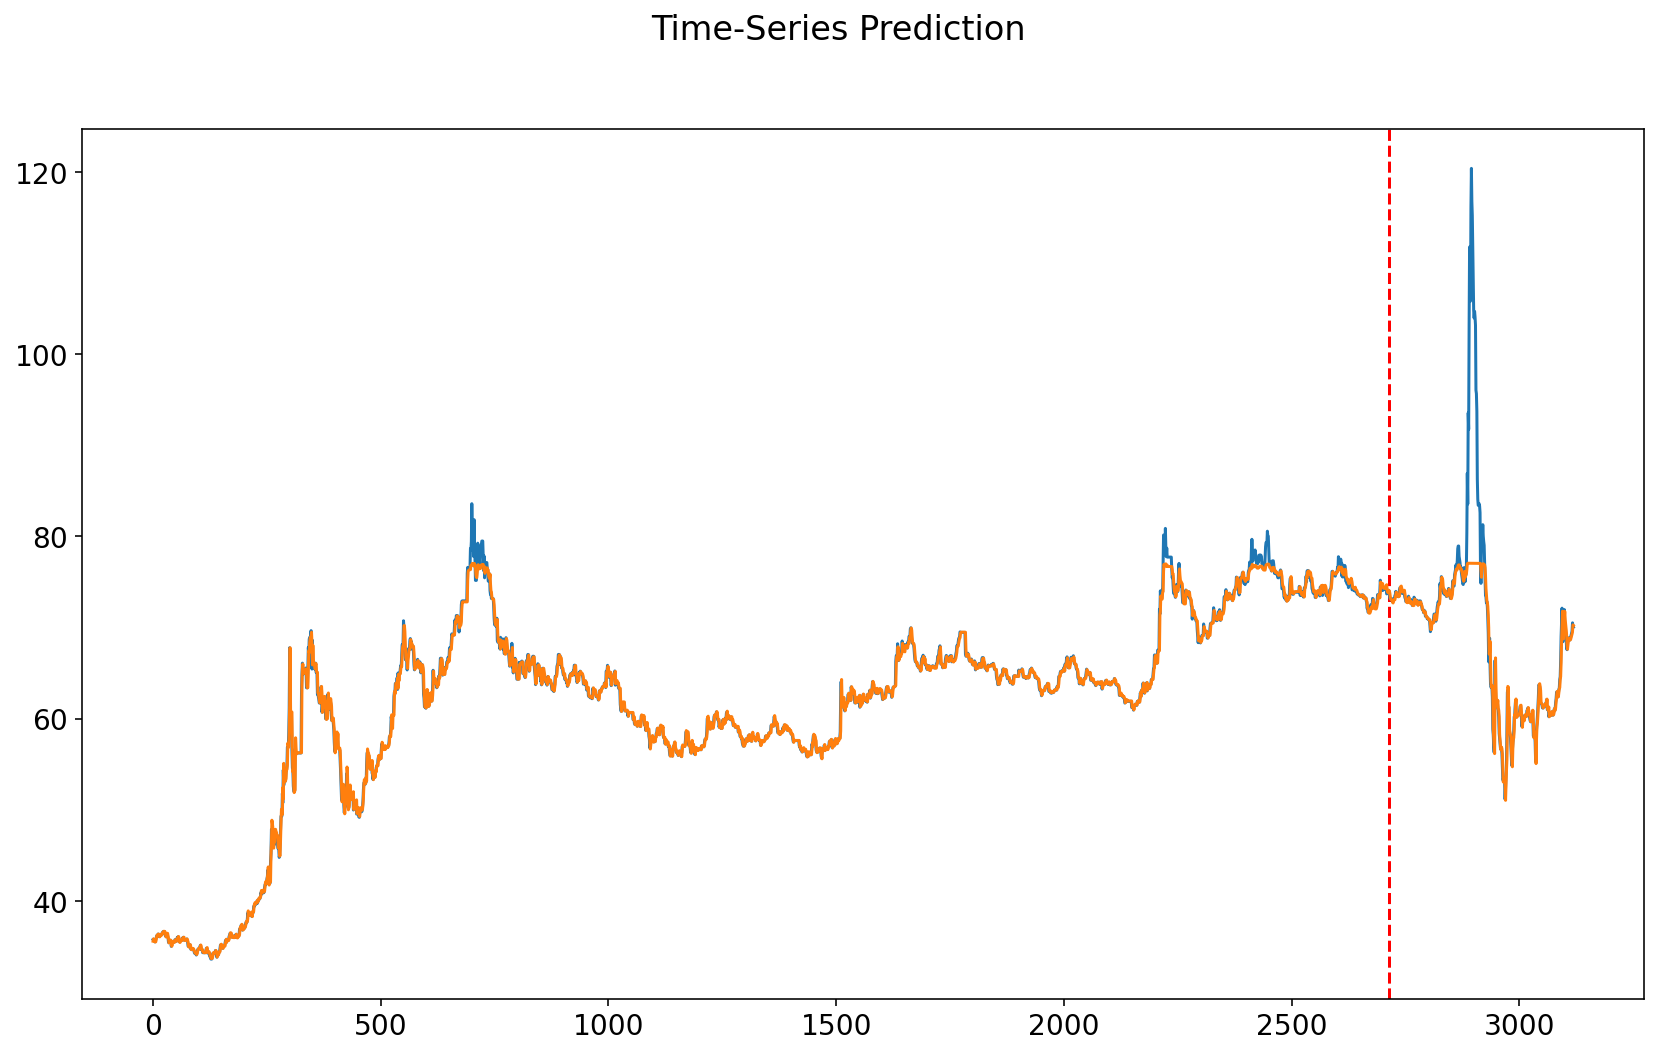

In [21]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Predict for week

In [22]:
pred_date = datetime.today().date()

In [23]:
lstm.eval()
pred_df = pd.DataFrame({'Дата':[], 'Курс доллара США':[]})

predictions = []
dates = []

for i in range(7):
    pred_date += addDays
    x = []
    x.append(df[-seq_length:])
    week = Variable(torch.Tensor(np.array(x)))
    output = lstm(week)
    df = np.append(df, np.array([np.array([output.item()])]), axis=0)
    
    dates.append(pred_date)
    predictions.append(output.item())

In [24]:
weekday_preds = []

for date, pred in zip(dates, predictions):
    if date.weekday() < 5:
        weekday_preds.append(pred)
    else:
        weekday_preds.append(weekday_preds[-1])

In [25]:
pred_df["Дата"] = dates
pred_df["Курс доллара США"] = weekday_preds
pred_df = pred_df.set_index("Дата")

In [26]:
pred_df

,Курс доллара США
Дата,
2023-02-07,70.309868
2023-02-08,70.334984
2023-02-09,70.344215
2023-02-10,70.352966
2023-02-11,70.352966
2023-02-12,70.352966
2023-02-13,70.377335


In [27]:
pred_df.to_csv('prediction.csv')

In [28]:
predictions

[70.30986785888672,
 70.3349838256836,
 70.3442153930664,
 70.35296630859375,
 70.36140441894531,
 70.3695297241211,
 70.37733459472656]